# Meshes

This example demonstrates the use of meshes in continuiti.

In this example, we will load a `Gmsh` file and train a physics-informed neural
operator.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import pathlib
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from continuiti.data import OperatorDataset
from continuiti.data.mesh import Gmsh
from continuiti.operators import DeepONet
from continuiti.trainer import Trainer
from continuiti.pde import div, grad, PhysicsInformedLoss

In [3]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

# Generate the mesh
import os
meshes_dir = pathlib.Path.cwd().joinpath("..", "data", "meshes")
geofile = meshes_dir.joinpath("mediterranean.geo").as_posix()
os.system(f"gmsh -2 {geofile}")

Info    : Running 'gmsh -2 mediterranean.geo


0

We use the `Gmsh` class to read a mesh from a file generated by Gmsh.

In [4]:
meshes_dir = pathlib.Path.cwd().joinpath("..", "data", "meshes")
gmsh_file = meshes_dir.joinpath("mediterranean.msh").as_posix()

mesh = Gmsh(gmsh_file)
vertices = mesh.get_vertices()

# We use longitude and latitude only and scale them to be in the range [-1, 1]
vertices = vertices[1:, :]
vertices -= vertices.mean(dim=1, keepdim=True)
vertices /= vertices[0, :].abs().max()

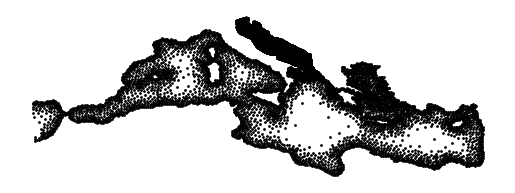

In [5]:
plt.scatter(vertices[0], vertices[1], 1, c="black")
plt.gca().axis("off")
plt.gca().set_aspect("equal")

## Problem Statement

Let's assume we have a set of temperature measurements and want to 
reconstruct a physically meaningful temperature distribution in the
whole mediterranean sea. We define a data set by generating random sensor
inputs and plot the first entry.

In [6]:
num_observation = 1
num_sensors = 5

x = torch.zeros(num_observation, 2, num_sensors)
u = torch.zeros(num_observation, 1, num_sensors)
y = torch.zeros(num_observation, 2, num_sensors)
v = torch.zeros(num_observation, 1, num_sensors)

for i in range(num_observation):

    # Select random sensor positions
    idx = torch.randperm(vertices.shape[1])[:num_sensors]
    x[i] = vertices[:, idx]

    # Generate random sensor measurements
    u[i] = torch.rand(1, num_sensors)
    
    # The mapped function equals u the sensors
    # (but we will add a physics-informed loss later w.r.t to all vertices)
    y[i] = x[i]
    v[i] = u[i]

dataset = OperatorDataset(x, u, y, v)

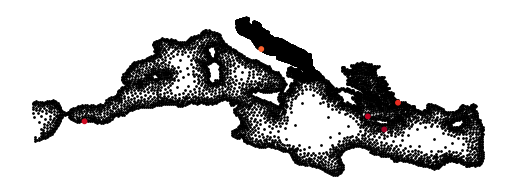

In [7]:
# Get a first observation from training set
u0 = torch.rand(num_sensors, 1)
x0, u0, _, _ = dataset[0]

# Plot
plt.scatter(vertices[0], vertices[1], 1, c="black")
plt.scatter(x0[0], x0[1], 10, u0, cmap="YlOrRd", vmin=-1, vmax=1)
plt.gca().axis("off")
plt.gca().set_aspect("equal")

## Neural Operator

In this example, we use a DeepONet architecture.

In [8]:
operator = DeepONet(dataset.shapes)

## Physics-informed loss

As we want to learn a physically meaningful completion, we define a
physics-informed loss function satisfying:

$$- \Delta v = 0$$

In [9]:
y_physics = vertices.clone().requires_grad_(True)[:, ::100] # Use a subset of vertices for the physics-informed loss
mse = torch.nn.MSELoss()

def pde(x, u, y, v):
    # Sensor measurements
    loss = mse(v, u)

    # Physics-informed loss w.r.t. all vertices
    w = lambda y: operator(x, u, y)
    Delta = div(grad(w))

    y_all = y_physics.repeat(u.shape[0], 1, 1).to(y.device)
    loss += (Delta(y_all)**2).mean()

    return loss

loss_fn = PhysicsInformedLoss(pde)

## Training

We train the neural operator using the physics-informed loss function. 

In [10]:
Trainer(operator, loss_fn=loss_fn).fit(dataset, tol=1e-2, epochs=10000)

Parameters: 5296  Device: mps
Epoch 3582/10000  Step  1/1  [====================]  27ms/step  [1:35min<2:51min] - loss/train = 9.9980e-03  - stopping criterion met



Logs(epoch=3582, step=1, loss_train=0.009997953660786152, loss_test=None)

## Evaluation

Let's evaluate the trained operator on our initial sensor measurements
and compute a test error.

In [11]:
x_test = x0.unsqueeze(0)
u_test = u0.unsqueeze(0)

test_loss = mse(operator(x_test, u_test, x_test), u_test)
print(f"loss/test = {test_loss.item():.4e}")


loss/test = 8.9704e-03


## Plotting
We can plot the mapped function on the whole mesh by using the cell 
information from the mesh file and pass it as `Triangulation` to matplotlib.

In [12]:
tri = Triangulation(vertices[0], vertices[1], mesh.get_cells())

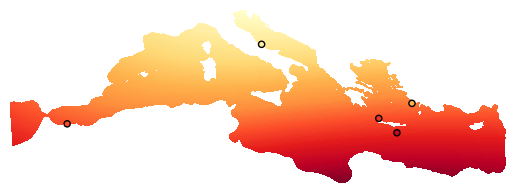

In [13]:
# Plot with contours
y_plot = vertices.unsqueeze(0)
v_plot = operator(x_test, u_test, y_plot).detach().squeeze()

# Triangulation
kwargs = {"vmin": v_plot.min(), "vmax": v_plot.max(), "cmap": "YlOrRd"}
cb = plt.tricontourf(tri, v_plot, levels=100, **kwargs)

# Add sensors
plt.scatter(x0[0], x0[1], 20, u0, edgecolors="k", **kwargs)

plt.gca().axis("off")
plt.gca().set_aspect("equal")